In [11]:
import os

import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

TABLE_NAME = "users_churn" # таблица с данными в postgres 
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "bvv_43" # напишите название вашего эксперимента
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = 'churn_model_bvv43'
FS_ASSETS = "fs_assets"

In [27]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

# загружаем данные
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)
df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
1,59,3957-SQXML,2017-04-01,NaT,Two year,No,Credit card (automatic),24.95,894.3,None,None,None,None,None,None,None,Female,0,Yes,Yes,Yes,0


In [28]:
#df = df.dropna()
#X = df.drop(['id','customer_id','begin_date','end_date','target'], axis=1) 
#y = df.target
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
#X_train.head(5)

In [29]:
# преобразования для категориальных признаков 

from sklearn.model_selection import train_test_split
from autofeat import AutoFeatRegressor, AutoFeatClassifier

cat_features = [
    'type',
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]

features = cat_features + num_features

target = ['target'] # колонка с таргетом вашей модели

split_column = "begin_date"
test_size = 0.2

df = df.sort_values(by=[split_column])

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=test_size,
    shuffle=False,
)

# автогенерация новых признаков
transformations = ("log", "sqrt", "1/", "abs")

afc = AutoFeatClassifier(categorical_cols=cat_features, transformations=transformations, feateng_steps=1, n_jobs=-1)

X_train_features = afc.fit_transform(X_train, y_train)
X_test_features = afc.transform(X_test)
X_train_features.head(5)

/home/mle-user/mle_projects/mle-mlflow/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,monthly_charges,total_charges,cat_type_Month-to-month,cat_type_One year,cat_type_Two year,cat_paperless_billing_No,cat_paperless_billing_Yes,cat_payment_method_Bank transfer (automatic),cat_payment_method_Credit card (automatic),cat_payment_method_Electronic check,cat_payment_method_Mailed check,cat_internet_service_DSL,cat_internet_service_Fiber optic,cat_internet_service_None,cat_online_security_No,cat_online_security_Yes,cat_online_security_None,cat_online_backup_No,cat_online_backup_Yes,cat_online_backup_None,cat_device_protection_No,cat_device_protection_Yes,cat_device_protection_None,cat_tech_support_No,cat_tech_support_Yes,cat_tech_support_None,cat_streaming_tv_No,cat_streaming_tv_Yes,cat_streaming_tv_None,cat_streaming_movies_No,cat_streaming_movies_Yes,cat_streaming_movies_None,cat_gender_Female,cat_gender_Male,cat_senior_citizen_0,cat_senior_citizen_1,cat_partner_No,cat_partner_Yes,cat_dependents_No,cat_dependents_Yes,cat_multiple_lines_No,cat_multiple_lines_Yes,cat_multiple_lines_None,1/total_charges
0,104.15,7689.95,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000130
1,92.45,6440.25,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.000155
2,117.8,8684.8,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000115
3,108.6,7690.9,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000130
4,108.05,7532.15,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000133


In [ ]:
estimator = RandomForestClassifier(n_estimators = 300)

# Инициализация Sequential Feature Selector для backward selection
sbs = SFS(estimator, # модель
    k_features=10,  # количество лучших для отбора
    forward=False, #True — для того, чтобы начать с пустого набора признаков, False — чтобы начать с полного набора признаков. 
    floating=False,# True — можно удалять, False — нельзя удалять ранее добавленные признаки,
    scoring='roc_auc', # критерий оценки производительности модели
    cv=4,               
    n_jobs=-1
)
# Обучение SBS на обучающем наборе
sbs = sbs.fit(X_train_features, y_train)

# Выбор признаков с помощью SBS
selected_features_sbs = sbs.k_feature_idx_

# Инициализация Sequential Feature Selector с включённым параметром floating для SFFS
sfs = SFS(estimator, # модель
    k_features=10,  # количество лучших для отбора
    forward=True, #True — для того, чтобы начать с пустого набора признаков, False — чтобы начать с полного набора признаков. 
    floating=False,# True — можно удалять, False — нельзя удалять ранее добавленные признаки,
    scoring='roc_auc', # критерий оценки производительности модели
    cv=4,               
    n_jobs=-1
)
# Обучение SBFS на обучающем наборе
sfs = sfs.fit(X_train_features, y_train)

# Выбор признаков с помощью SBFS
selected_features_sfs = sfs.k_feature_idx_

# Объединение индексов выбранных признаков из SBS и SBFS для обучения
selected_features = list(set(selected_features_sbs).union(set(selected_features_sfs)))
selected_features


/home/mle-user/mle_projects/mle-mlflow/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-mlflow/.venv/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mle-user/mle_projects/mle-mlflow/.venv/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mle-user/mle_projects/mle-mlflow/.venv/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when

[2, 3, 4, 6, 9, 11, 12, 14, 19, 20, 21, 23, 28, 32, 36]

In [31]:
print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)
print(sfs.k_feature_names_)


print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)
print(sbs.k_feature_names_)


Sequential Forward Selection (k=10)
CV Score:
0.8285181633602359
('cat_type_Month-to-month', 'cat_type_One year', 'cat_type_Two year', 'cat_payment_method_Electronic check', 'cat_internet_service_Fiber optic', 'cat_online_security_No', 'cat_online_backup_None', 'cat_device_protection_No', 'cat_device_protection_Yes', 'cat_streaming_tv_None')

Sequential Backward Selection
CV Score:
0.7887638057025698
('cat_type_Month-to-month', 'cat_type_Two year', 'cat_paperless_billing_Yes', 'cat_payment_method_Electronic check', 'cat_internet_service_DSL', 'cat_online_security_No', 'cat_device_protection_Yes', 'cat_tech_support_No', 'cat_gender_Female', 'cat_partner_No')


In [32]:
# таблица с результатами отбора
#feature_idx — кортеж индексов отобранных признаков.
#cv_scores — список индивидуальных оценок на перекрёстной проверке (CV). Информация в следующих столбцах также приводится по перекрёстной проверке.
#avg_score — средняя оценка.
#ci_bound — граница доверительного интервала средней оценки.
#std_dev — стандартное отклонение средней оценки.
#std_err — стандартная ошибка средней оценки.


sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)","[0.7239870754433423, 0.8210700330628193, 0.748...",0.737285,"(cat_type_Month-to-month,)",0.094521,0.058965,0.034044
2,"(2, 12)","[0.8050571085061617, 0.8422467688608356, 0.799...",0.803723,"(cat_type_Month-to-month, cat_internet_service...",0.042409,0.026456,0.015275
3,"(2, 9, 12)","[0.8310204388337843, 0.8489089269612263, 0.819...",0.82066,"(cat_type_Month-to-month, cat_payment_method_E...",0.038475,0.024002,0.013857
4,"(2, 9, 12, 14)","[0.8404869251577998, 0.8512714156898106, 0.823...",0.827101,"(cat_type_Month-to-month, cat_payment_method_E...",0.035253,0.021992,0.012697
5,"(2, 9, 12, 14, 20)","[0.8427276825969341, 0.8521535918244665, 0.824...",0.828533,"(cat_type_Month-to-month, cat_payment_method_E...",0.035156,0.021932,0.012662
6,"(2, 4, 9, 12, 14, 20)","[0.8438127442140065, 0.8498031259392846, 0.820...",0.827241,"(cat_type_Month-to-month, cat_type_Two year, c...",0.034886,0.021763,0.012565
7,"(2, 4, 9, 12, 14, 20, 28)","[0.8521490832581905, 0.8506327021340547, 0.818...",0.828605,"(cat_type_Month-to-month, cat_type_Two year, c...",0.039077,0.024378,0.014075
8,"(2, 3, 4, 9, 12, 14, 20, 28)","[0.8528373910429816, 0.851161707243763, 0.8176...",0.82833,"(cat_type_Month-to-month, cat_type_One year, c...",0.040706,0.025394,0.014661
9,"(2, 3, 4, 9, 12, 14, 20, 21, 28)","[0.8517643522693117, 0.8502930568079351, 0.817...",0.828378,"(cat_type_Month-to-month, cat_type_One year, c...",0.038811,0.024212,0.013979
10,"(2, 3, 4, 9, 12, 14, 19, 20, 21, 28)","[0.8520769461977757, 0.8506837992185151, 0.817...",0.828518,"(cat_type_Month-to-month, cat_type_One year, c...",0.039093,0.024388,0.01408


In [33]:
# сохраним

os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

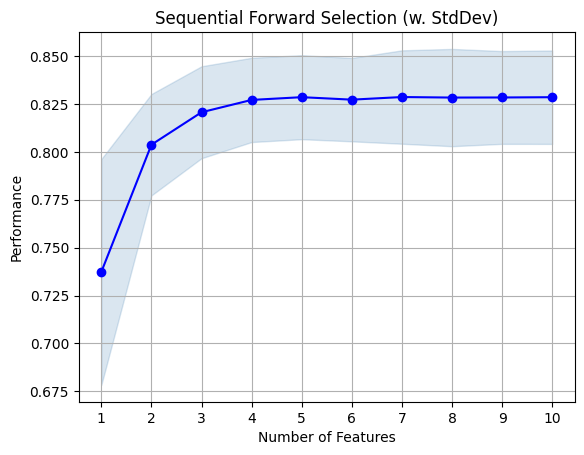

<Figure size 640x480 with 0 Axes>

In [35]:
# графики отбора признаков для методов SFS и SBS

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig("fs_assets/sfs.png")

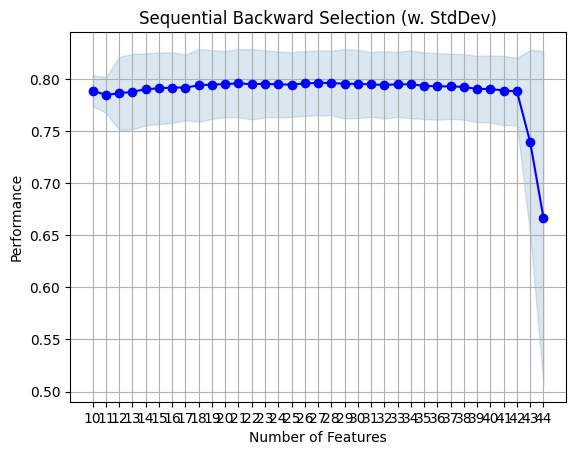

<Figure size 640x480 with 0 Axes>

In [36]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig("fs_assets/sbs.png") 

In [37]:
top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

# объединение списков
union_features1 = list(set(top_sfs + top_sbs)) #list(set(selected_features_sbs).union(set(selected_features_sfs)))
union_features = list(set(top_sbs) | set(top_sfs)) #list(set(selected_features_sbs).union(set(selected_features_sfs)))
union_features

['cat_tech_support_No',
 'cat_device_protection_Yes',
 'cat_internet_service_Fiber optic',
 'cat_type_Two year',
 'cat_streaming_tv_None',
 'cat_device_protection_No',
 'cat_type_Month-to-month',
 'cat_online_backup_None',
 'cat_online_security_No',
 'cat_internet_service_DSL',
 'cat_type_One year',
 'cat_payment_method_Electronic check',
 'cat_paperless_billing_Yes',
 'cat_gender_Female',
 'cat_partner_No']

In [40]:
# пересечение списков
interc_features1 = set(top_sfs).intersection(top_sbs)
interc_features = list(set(top_sbs) & set (top_sfs))
interc_features

['cat_online_security_No',
 'cat_type_Two year',
 'cat_payment_method_Electronic check',
 'cat_type_Month-to-month',
 'cat_device_protection_Yes']

In [49]:
# определяем основные credentials, которые нужны для подключения к MLflow
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS)
run_id

2026-01-07 17:34:29,963 INFO: Found credentials in environment variables.


'09155f32ad2f43a2a4dac8712f882e18'

In [54]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score,log_loss, confusion_matrix

# версия 1 - обучаем на пересечении списков
model = CatBoostClassifier()

# обучение модели
model = model.fit(X_train_features[interc_features], y_train)

# считаем метрики
prediction = model.predict(X_test_features[interc_features])
probas = model.predict_proba(X_test_features[interc_features])

metrics = {}

confusion_matrix_data = confusion_matrix(y_test, prediction, normalize='all')
_, err1, _, err2 = confusion_matrix_data.ravel()
auc = roc_auc_score(y_test, probas[:,1])
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)
logloss = log_loss(y_test, prediction)

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

# регистрируем модель и логируем метрики
pip_requirements = "./requirements.txt"
signature =  mlflow.models.infer_signature(X_test_features[interc_features].head(2), model.predict(X_test_features[interc_features].head(2)))
input_example = X_test_features[interc_features].head(2)

RUN_NAME = "feature_selection_intersection"


# создаём эксперимент если его нет и записываем в него тестовую информацию
if not mlflow.get_experiment_by_name(EXPERIMENT_NAME):
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) 
else:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_metrics(metrics)
    model_info = mlflow.sklearn.log_model( 
#    model_info = mlflow.catboost.log_model( 
        artifact_path='models',
        sk_model=model,
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example
        #await_registration_for=60
		)
run_id

Learning rate set to 0.021554
0:	learn: 0.6762265	total: 1.67ms	remaining: 1.66s
1:	learn: 0.6612500	total: 3.07ms	remaining: 1.53s
2:	learn: 0.6475621	total: 4.29ms	remaining: 1.43s
3:	learn: 0.6335695	total: 5.84ms	remaining: 1.45s
4:	learn: 0.6209581	total: 7.14ms	remaining: 1.42s
5:	learn: 0.6092575	total: 8.27ms	remaining: 1.37s
6:	learn: 0.5987125	total: 9.43ms	remaining: 1.34s
7:	learn: 0.5885545	total: 10.6ms	remaining: 1.31s
8:	learn: 0.5779501	total: 11.9ms	remaining: 1.3s
9:	learn: 0.5686245	total: 13ms	remaining: 1.29s
10:	learn: 0.5603664	total: 14.2ms	remaining: 1.27s
11:	learn: 0.5519911	total: 15.4ms	remaining: 1.27s
12:	learn: 0.5433755	total: 16.8ms	remaining: 1.28s
13:	learn: 0.5358635	total: 18.2ms	remaining: 1.28s
14:	learn: 0.5287984	total: 19.4ms	remaining: 1.28s
15:	learn: 0.5218431	total: 20.8ms	remaining: 1.28s
16:	learn: 0.5153168	total: 22.2ms	remaining: 1.28s
17:	learn: 0.5091928	total: 23.5ms	remaining: 1.28s
18:	learn: 0.5040470	total: 24.9ms	remaining: 1

Registered model 'churn_model_bvv43' already exists. Creating a new version of this model...
2026/01/07 17:47:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_model_bvv43, version 8
Created version '8' of model 'churn_model_bvv43'.


'3cf6d8e9d0984cd7b5353266da8c39b0'

In [55]:
metrics

{'err1': 0.1256210078069553,
 'err2': 0.25691980127750175,
 'auc': 0.7153373861410134,
 'precision': 0.6716141001855288,
 'recall': 0.5402985074626866,
 'f1': 0.5988420181968569,
 'logloss': 12.406793395118394}

In [58]:
# версия 2 - обучаем на объединении списков
model = CatBoostClassifier()

# обучение модели
model = model.fit(X_train_features[union_features], y_train)

# считаем метрики
prediction = model.predict(X_test_features[union_features])
probas = model.predict_proba(X_test_features[union_features])

metrics = {}

confusion_matrix_data = confusion_matrix(y_test, prediction, normalize='all')
_, err1, _, err2 = confusion_matrix_data.ravel()
auc = roc_auc_score(y_test, probas[:,1])
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)
logloss = log_loss(y_test, prediction)

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

# регистрируем модель и логируем метрики
pip_requirements = "./requirements.txt"
signature =  mlflow.models.infer_signature(X_test_features[union_features].head(2), model.predict(X_test_features[union_features].head(2)))
input_example = X_test_features[union_features].head(2)

RUN_NAME = "feature_selection_union"


# создаём эксперимент если его нет и записываем в него тестовую информацию
if not mlflow.get_experiment_by_name(EXPERIMENT_NAME):
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) 
else:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_metrics(metrics)
    model_info = mlflow.sklearn.log_model( 
#    model_info = mlflow.catboost.log_model( 
        artifact_path='models',
        sk_model=model,
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example
        #await_registration_for=60
		)
run_id

Learning rate set to 0.021554
0:	learn: 0.6762448	total: 2.06ms	remaining: 2.06s
1:	learn: 0.6596112	total: 4.17ms	remaining: 2.08s
2:	learn: 0.6450230	total: 5.52ms	remaining: 1.83s
3:	learn: 0.6302435	total: 10.7ms	remaining: 2.66s
4:	learn: 0.6155362	total: 14.2ms	remaining: 2.82s
5:	learn: 0.6026489	total: 15.6ms	remaining: 2.58s
6:	learn: 0.5902098	total: 17.6ms	remaining: 2.49s
7:	learn: 0.5783815	total: 19.5ms	remaining: 2.42s
8:	learn: 0.5687785	total: 20.8ms	remaining: 2.29s
9:	learn: 0.5591378	total: 22.5ms	remaining: 2.23s
10:	learn: 0.5513943	total: 23.8ms	remaining: 2.14s
11:	learn: 0.5418740	total: 25.7ms	remaining: 2.12s
12:	learn: 0.5326674	total: 27.7ms	remaining: 2.1s
13:	learn: 0.5251364	total: 29.3ms	remaining: 2.06s
14:	learn: 0.5170766	total: 31.3ms	remaining: 2.06s
15:	learn: 0.5101447	total: 32.9ms	remaining: 2.02s
16:	learn: 0.5035741	total: 35ms	remaining: 2.02s
17:	learn: 0.4974038	total: 37ms	remaining: 2.02s
18:	learn: 0.4915329	total: 39ms	remaining: 2.02s

Registered model 'churn_model_bvv43' already exists. Creating a new version of this model...
2026/01/07 17:49:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_model_bvv43, version 10
Created version '10' of model 'churn_model_bvv43'.


'98215ac352ce4e108e5e7b60e2a13d52'

In [59]:
metrics

{'err1': 0.08942512420156139,
 'err2': 0.22782114975159687,
 'auc': 0.7345747581443257,
 'precision': 0.7181208053691275,
 'recall': 0.4791044776119403,
 'f1': 0.5747538048343778,
 'logloss': 12.15098322202317}

In [ ]:
select * from runs join model_versions on runs.run_uuid=model_versions.run_id 
where runs.name in ('churn_model_bvv43', 'churn_model_bvv43') 
and runs.run_uuid in ('3cf6d8e9d0984cd7b5353266da8c39b0', '98215ac352ce4e108e5e7b60e2a13d52') 
and model_versions.name = 'churn_model_bvv43' 
and version in (8, 10)